# Data Augmentation

##### Keywords: data augmentation, gibbs sampler, MCMC

## TL;DR
Data Augmentation is an intinsely powerful tool for sampling from otherwise intractible distributions. It is a generalization of Gibbs sampling and an intuitive vantage point for understanding many algorithms in this class, e.g. Expectation-Maximization and Hamiltonian Monte Carlo.

In Data Augmentation we invent a new variable or set of variables Y and specify conditionals p(Y|X) and p(X|Y), where X is the variables we want to sample. If p(X) [which can be found from the conditionals] is still correct we can sample by alternating updates to X and Y (like we do in Gibbs) and then dropping the Y values from the final sample. It works because it is a version of MH with acceptance probability 1.

## The Plan
We've given some $p(x)$ to sample from. We can't. So we invent a new variable Y and specify its joint distribution with X. We choose the joint distribution to be such that the marginal $p(x) = \int p(x|y)p(y)dy$ is the p(x) we want to sample from, and where $p(x \vert y)$ and $p(y \vert x)$ can be found and sampled from.

Our sampling algorithm is then:

1. Draw y from the conditional $Y\sim p_{Y \vert X}(. \vert x)$
2. Draw a new x from the conditional $X_{n+1} \sim p_{X \vert Y}(. \vert y)$ 
3. Repeat

In parctice, we don't need to write down the formula for the joint distribution: we can do all our math with just $p_{Y \vert X}$ and $p_{X \vert Y}$. So an equivalent satement is that in variable augmentation we invent a Y variable and give it cleverly chosen conditional distributions with the existing variable.

Gibbs is a special case of data augmentation where the Y variable is pre-existing and the conditionals are handed to us on a sliver platter. In more general settings, we invent the conditionals and verify that the X marginal is still correct.

In just a second, we'll prove the algorithm above is just MH with a paticular transition kernel. First, though, an example to show the process.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

## Example


Suppose that $p_X$ is the standard normal density, i.e., 

$$p(x) = e^{-x^2/2}/\sqrt{2\pi}$$.

We'll pretend we dont know how to sample from it, becuase we've forgotten Box-Muller and MH and so on.

Invent Y and define it via its joint distribution with X:

$$p(x, y) = 1/(\sqrt{2\pi}) \exp{\left\{-(x^2 - \sqrt{2} xy + y^2) \right\} } $$

which is a bivariate normal density with means equal to zero, variances equal to one, and correlation equal to $1/\sqrt{2}$. We could have chosen X and Y to have any joint distribution, but we chose this one becuase 1) it has the correct marginal for X 2) the conditional distirbutions are easy.

The two conditionals are normal (a property of jointly normal RVs). We can find them either looking them up or by completing the square.

$$ 
Y \vert X = x \, \, \sim N(x/\sqrt{2}, 1/2) \,\,\,  \rm{and} \,\,\, X \vert Y= y \,\,\sim N(y/\sqrt{2}, 1/2) $$

#### Sampling
We draw samples from the conditionals, as in Gibbs, and if we dicard the Y values the Xs will have the target distribution. Note that we couldn't sample the Xs directly. Inventing Y was key.

In [2]:
N=100000
x=np.zeros(N)
x[0] = np.random.rand() # INITIALIZE
for i in np.arange(1,N):
    Y=sp.stats.norm.rvs(x[i-1]/np.sqrt(2), 0.5)
    x[i]=sp.stats.norm.rvs(Y/np.sqrt(2), 0.5)

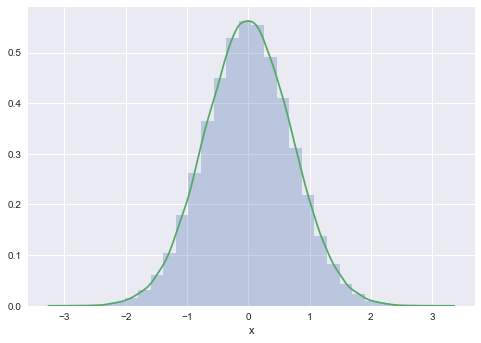

In [3]:
plt.hist(x, bins=30, alpha=0.3, normed=True);
sns.kdeplot(x)
plt.xlabel('x');

## Sampling via Data Augmentation is Metropolis-Hastings
In variable augmentation our MH proposal distribution is:

$$ h(x' \vert x) = p(X'=x'|X=x) = \int_Y' p(x' \vert y') \, p(y' \vert x)\, dy' $$

That is, the probability of transition from x to x' is found as the probability of going from $(x,y)$ to $(x',y')$, integrated across all possible values of y'. In other words, it's the probability of getting from $(x,y)$ to $(x,y')$ to $(x',y')$, but considering all possible values of y'.

Even if y and y' are vectors (i.e. if we've included multiple auxillary variables) we switch from a single integral over y' to a multiple integral over each component of y, but the result is the same.

We need to show that we get to skip the "do we reject" step of MH.

The acceptance criteria is 
$$A =min\left(1, \frac{p(x')}{p(x)}\frac{h(x,x')}{h(x',x)}\right)$$
Subbing in:
$$min\left(1, \frac{p(x')}{p(x)}\frac{p(x|x')}{p(x'|x)}\right)$$
Collecting numerators and denominators:
$$min\left(1, \frac{p(x|x')p(x')}{p(x'|x)p(x)}\right)$$
Combining conditional probability:
$$min\left(1, \frac{p(x,x')}{p(x',x)}\right)$$
$$min\left(1, 1\right)$$
So we always accept.

#### Summary
Ergo, we can augment with whatever we want and simply alternate sampling from the [unknown/added] Ys given the Xs and then from the [known/preexisting] Xs given the just-obtained Ys. 

The trick is specifying the joint distribution of the new variables such that 1) the X marginal remains intact and 2) the conditionals Y|X and X|Y can be found and sampled from.

Of course, even among conditionals with the desired properties there are better and worse choices, akin to choosing a wider/narrow proposal distribution in MH.